In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [13]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/custom/final.py')
root='../dataset/'

epoch = 'best_bbox_mAP_epoch_19'


cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/swinadamw20cas_aug_trash'

#cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [17]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [18]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

Use load_from_local loader


In [19]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                ] 1/4871, 0.9 task/s, elapsed: 1s, ETA:  5650s

/opt/ml/detection/new_mmdetection/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/detection/new_mmdetection/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 3.2 task/s, elapsed: 1524s, ETA:     0s

In [20]:
output

[[array([[4.80221558e+02, 5.92801025e+02, 5.85487183e+02, 6.57434937e+02,
          1.44980893e-01],
         [5.00291016e+02, 5.95555786e+02, 5.49898071e+02, 6.38809021e+02,
          1.19365975e-01],
         [1.50983429e+02, 4.24735962e+02, 2.04454254e+02, 4.53094696e+02,
          8.91815424e-02]], dtype=float32),
  array([[5.66108643e+02, 1.06158188e+02, 7.59381714e+02, 3.59326904e+02,
          9.72889185e-01],
         [6.39217041e+02, 1.72231644e+02, 7.46508057e+02, 3.43640259e+02,
          6.43638432e-01],
         [6.40146057e+02, 2.52912292e+02, 7.37887329e+02, 3.43938965e+02,
          3.03369254e-01],
         [2.43605469e+02, 6.81768738e+02, 3.01416809e+02, 7.49664062e+02,
          2.08918840e-01],
         [5.75491089e+02, 1.66774353e+02, 6.92441895e+02, 3.58159027e+02,
          1.98086143e-01],
         [4.28240540e+02, 4.51977386e+02, 5.67118774e+02, 6.65137878e+02,
          1.76051676e-01],
         [1.50983429e+02, 4.24735962e+02, 2.04454254e+02, 4.53094696e+02,


In [21]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.14498089 480.22156 592.801 585.4872 657.43...,test/0000.jpg
1,0 0.3565709 638.9922 643.7827 684.97687 836.75...,test/0001.jpg
2,0 0.5237082 880.7029 467.09613 1021.77155 636....,test/0002.jpg
3,9 0.9898181 155.16644 263.43185 910.22876 812....,test/0003.jpg
4,0 0.3887472 427.04092 414.45663 655.6471 567.8...,test/0004.jpg


In [22]:
import json
import random
import pandas as pd

import cv2
import matplotlib.pyplot as plt

In [23]:
def get_file_path(json_file, image_num):
    file_path = json_file['images'][image_num]['file_name']
    return file_path


def get_annotations(json_file, image_num):
    anns = [ann for ann in json_file['annotations'] if ann['image_id'] == image_num]
    return anns


def read_image(dataset_path, file_path):
    image = cv2.imread(dataset_path + file_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def plot_bbox(image, anns):
    for ann in anns:
        xmin, ymin, w, h = map(int, ann['bbox'])
        image = cv2.rectangle(image, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 255), 3)
    plt.imshow(image)

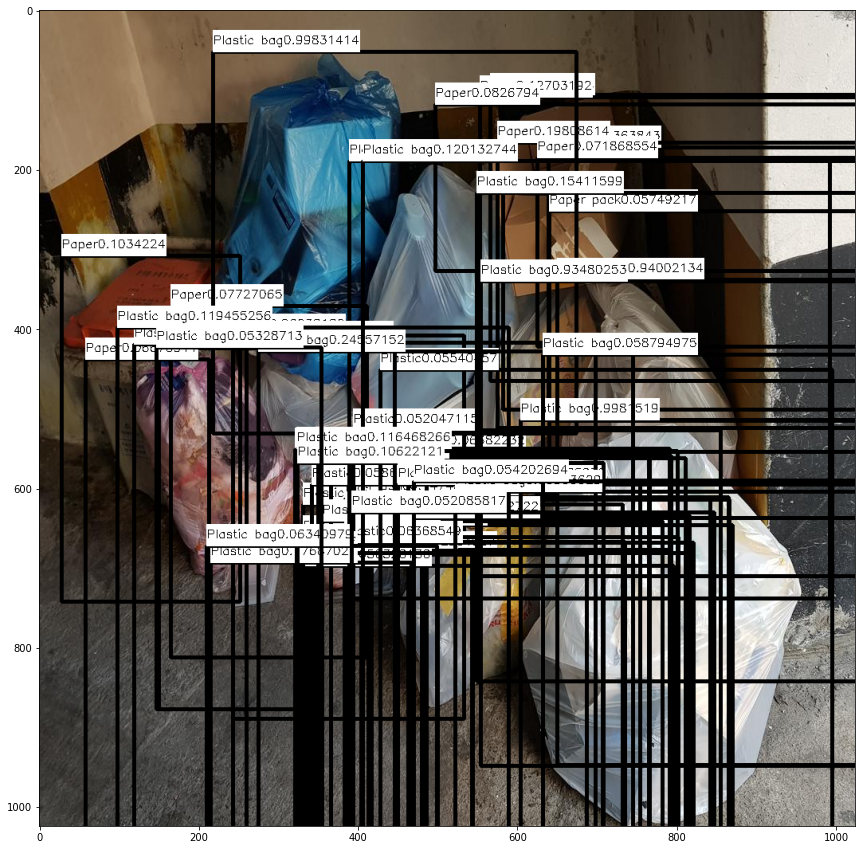

In [30]:
import math
plt.figure(figsize=(15,15))
bbox_inform = []
idx = 0
for i in range(len(submission)):
    if len(submission['PredictionString'].iloc[i].split(' ')[:-1]) % 6 == 0:
        dummy = [list(map(float, submission['PredictionString'].iloc[i].split(' ')[:-1])), submission['image_id'].iloc[i]]
        bbox_inform.append(dummy)
    # 바운딩 박스 사각형 그리기\
dataset_path = '../dataset/'
img = read_image(dataset_path, bbox_inform[idx][1])
for i in range(int(len(bbox_inform[idx][0]) / 6)):
    c, score, xmin, ymin, w, h = bbox_inform[idx][0][i * 6 : i * 6 + 6]
    c, xmin, ymin, w, h =int(c), int(xmin), int(ymin), int(w), int(h)
    if score > 0.0:
        img = cv2.rectangle(img, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 0), 3)
        # 클래스 글자 넣기
        text_size, _ = cv2.getTextSize(str(classes[c]) + str(score), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_w, text_h = text_size
        if xmin - text_h < 1:
            cv2.rectangle(img, (xmin, ymin), (xmin + text_w, ymin + 15 + text_h), [255,255,255], -1)
            img = cv2.putText(img, str(classes[c]) + str(score), (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        else:
            cv2.rectangle(img, (xmin, ymin - 15 - text_h), (xmin + text_w, ymin), [255,255,255], -1)
            img = cv2.putText(img, str(classes[c]) + str(score), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
plt.imshow(img)

In [ ]:
image_num = random.randint(0, len(train_json['images']) - 1)
file_path = get_file_path(train_json, image_num)
anns = get_annotations(train_json, image_num)
image = read_image(dataset_path, file_path)
plot_bbox(image, anns)

NameError: name 'train_json' is not defined

In [ ]:
dataset_path = '../dataset'
file_name = f"{dataset_path}/train.json"

class ReadCOCOjson:
    def __init__(self, json_file: str) -> None:
        with open(json_file, 'r') as f:
            self.json_dict = json.load(f) 
        print(f"json_key: {self.json_dict.keys()}")
        self.images_df = pd.DataFrame(self.json_dict['images'])
        self.annotations_df = pd.DataFrame(self.json_dict['annotations'])
    
    def get_extra_coord(self):
        bbox_array = np.array(self.annotations_df['bbox'].to_list())
        # x
        self.annotations_df['x_min'] = bbox_array[:, 0]
        self.annotations_df['x_center'] = bbox_array[:, 0] + bbox_array[:, 2]/2
        self.annotations_df['x_max'] = bbox_array[:, 0] + bbox_array[:, 2]
        # y
        self.annotations_df['y_min'] = bbox_array[:, 1]
        self.annotations_df['y_center'] = bbox_array[:, 1] + bbox_array[:, 3]/2
        self.annotations_df['y_max'] = bbox_array[:, 1] + bbox_array[:, 3]
        # w
        self.annotations_df['w'] = bbox_array[:, 2]
        # h
        self.annotations_df['h'] = bbox_array[:, 3]

coco_json = ReadCOCOjson(file_name)
coco_json.get_extra_coord()
coco_json.annotations_df

json_key: dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


,image_id,category_id,area,bbox,iscrowd,id,x_min,x_center,x_max,y_min,y_center,y_max,w,h
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,471.50,745.4,193.7,428.55,663.4,547.8,469.7
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,28.80,57.6,407.4,497.70,588.0,57.6,180.6
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,72.30,144.6,455.6,546.40,637.2,144.6,181.6
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,859.45,996.6,313.4,439.35,565.3,274.3,251.9
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,470.05,586.9,671.0,722.70,774.4,233.7,103.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139,0.0,472.05,944.1,116.2,523.25,930.3,944.1,814.1
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140,302.1,434.70,567.3,439.3,547.35,655.4,265.2,216.1
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141,511.3,540.65,570.0,451.1,466.20,481.3,58.7,30.2
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142,255.0,390.85,526.7,421.4,518.95,616.5,271.7,195.1
